In [1]:
!nvidia-smi

Mon Aug 24 09:34:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 24%   25C    P8    12W / 180W |   7751MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
| 24%   26C    P8     6W / 180W |   7751MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [7]:
import sys
import numpy as np
import pickle
from functools import partial
import tensorflow as tf
import scipy

from scipy.io import loadmat
from keras.layers import Input

from vdae.networks import VDAE, SpectralNet
from vdae.vdae_util import *

%matplotlib inline

# DATASET

In [30]:
dataset = 'loop'

if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
elif dataset == 'coil20hr':
    d_in = scipy.io.loadmat('COIL20_UNPROC_128.mat')
    X = d_in['X'] / np.max(d_in['X'])
    Y = d_in['Y']-1
    Y = Y.reshape(-1)
    x_train, x_test = X.reshape((len(X), -1)), X.reshape((len(X), -1))
    y_train, y_test = Y, Y
    latent_dim = 10
elif dataset == 'bulldog':
    (x_train, y_train), (x_test, y_test) = generate_bulldog()
    latent_dim = 3
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=5000, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'faces':
    (x_train, y_train), (x_test, y_test) = generate_faces()
    latent_dim = 5

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if 'mnist' not in dataset and 'cifar' not in dataset and 'bulldog' not in dataset and 'gaussian_grid' not in dataset:
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b

arch = [
    {'type': 'relu', 'size': 500},
    {'type': 'linear', 'size': latent_dim},
    ]

# TRAIN SPECTRALNET

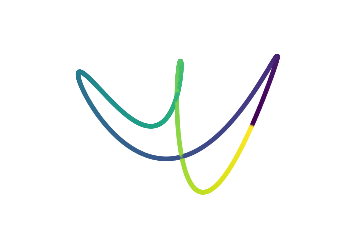

In [31]:
g = plot(x_train, y_train)

In [8]:
n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }

In [9]:
spectral_net = SpectralNet(inputs=inputs, arch=arch,
                spec_reg=None, y_true=y_true, y_train_labeled_onehot=y_train_labeled_onehot,
                n_clusters=n_clusters, affinity='full', scale_nbr=3, n_nbrs=12, 
                batch_sizes=batch_sizes, siamese_net=None, 
                x_train=x_train, have_labeled=False)

In [10]:
spectral_net.train(
            x_train, np.zeros_like(x_train[0:0]), x_test,
            lr=1e-5, drop=0.1, patience=20, num_epochs=200)

Epoch: 0, val_loss=0.000000
Epoch: 0, loss=0.029693, val_loss=0.000157
Epoch: 1, loss=0.027811, val_loss=0.000121
Epoch: 2, loss=0.017661, val_loss=0.000072
Epoch: 3, loss=0.009942, val_loss=0.000041
Epoch: 4, loss=0.005851, val_loss=0.000027
Epoch: 5, loss=0.004070, val_loss=0.000021
Epoch: 6, loss=0.003271, val_loss=0.000018
Epoch: 7, loss=0.002867, val_loss=0.000016
Epoch: 8, loss=0.002623, val_loss=0.000016
Epoch: 9, loss=0.002443, val_loss=0.000014
Epoch: 10, loss=0.002372, val_loss=0.000014
Epoch: 11, loss=0.002267, val_loss=0.000013
Epoch: 12, loss=0.002237, val_loss=0.000013
Epoch: 13, loss=0.002205, val_loss=0.000013
Epoch: 14, loss=0.002149, val_loss=0.000013
Epoch: 15, loss=0.002142, val_loss=0.000013
Epoch: 16, loss=0.002104, val_loss=0.000013
Epoch: 17, loss=0.002103, val_loss=0.000012
Epoch: 18, loss=0.002100, val_loss=0.000012
Epoch: 19, loss=0.002065, val_loss=0.000012
Epoch: 20, loss=0.002048, val_loss=0.000012
Epoch: 21, loss=0.002052, val_loss=0.000012
Epoch: 22, los

(array([0.02969297, 0.02781099, 0.01766059, 0.00994195, 0.00585073,
        0.00407039, 0.00327086, 0.00286719, 0.00262285, 0.00244259,
        0.00237183, 0.00226689, 0.00223695, 0.00220491, 0.00214865,
        0.00214159, 0.00210373, 0.00210303, 0.00210049, 0.00206509,
        0.00204793, 0.002052  , 0.00206129, 0.00203102, 0.00201233,
        0.0020442 , 0.00205191, 0.00202254, 0.00200698, 0.00197561,
        0.00197555, 0.00200267, 0.00196973, 0.00197218, 0.00199966,
        0.00200805, 0.0019983 , 0.00196694, 0.00198017, 0.00195684,
        0.00196989, 0.00197348, 0.00196403, 0.00199241, 0.00196047,
        0.00198068, 0.00197022, 0.00196643, 0.00195104, 0.00194036,
        0.00196658, 0.00195669, 0.00195659, 0.00195139, 0.00197345,
        0.00197065, 0.00195262, 0.00199088, 0.00194889, 0.0019325 ,
        0.00195432, 0.00193971, 0.00194679, 0.00196   , 0.00195557,
        0.00193744, 0.00195069, 0.0019608 , 0.00194518, 0.00197688,
        0.00195154, 0.00195354, 0.00194324, 0.00

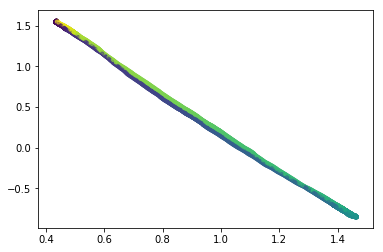

In [11]:
y_pred = spectral_net.predict(x_train)
g = plot(y_pred[:,:3], y_train.reshape(-1,))

# TRAIN VDAE

In [12]:
# divide k by the difference in batch size
svg_bsize = 288
svg_k = 2
# number of layers in the decoder
conv_decoder = 5 if 'conv' in dataset else -1
# number of layers in the encoder that creates the covariance matrix
svg_arch = [1024, 1024, 512]
# svg_arch = svg_arch = [a['size'] for a in arch]

svg = VDAE(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[1:], k=svg_k, alpha=1., arch=svg_arch)

IMPORTANT (?, 2)
z_mu_nb (?, 2, 2)
IMPORTANT (?, 2)
important input shape (?, 3)
NEIGHBORHOOD AND RECON SHAPES: (?, 3) (?, 3)


In [13]:
# SHOW EMBEDDINGS WITH IM_SCATTER
# _ = imscatter(v[:,1], v[:,2], x_all)
if 'mnist' in dataset or 'cifar' in dataset or 'coil' in dataset or 'faces' in dataset:
    print("WHAT")
    zoom = 1
    if 'mnist' in dataset:
        img_shape = (28, 28)
    elif 'cifar' in dataset:
        img_shape = (32, 32, 3)
    elif 'coil' in dataset and 'hr' in dataset:
        img_shape = (128, 128)
        zoom = 0.2
    elif 'coil' in dataset:
        img_shape = (32, 32)
    elif 'faces' in dataset:
        img_shape = (28, 20)
        zoom = 2
    %matplotlib inline
    _ = imscatter(y_pred[p,0], y_pred[p,1], x_train[p], shape=img_shape, zoom=zoom)
    plt.figure()
    _ = imscatter(y_pred_svg_embedded[:,0], y_pred_svg_embedded[:,1], x_train[p], shape=img_shape, zoom=zoom)

In [ ]:
svg.train(x_train, epochs=2000, batch_size=svg_bsize, full_batch=True)

0 [VAE loss: 40829.01953125] [kl_loss: 25551.6484375] [neighborhood_loss: 1105.75146484375]
vector covariance:
 [[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0.5213373 0.7081623]]
25 [VAE loss: 8463.4365234375] [kl_loss: 7963.35107421875] [neighborhood_loss: 533.671630859375]
vector covariance:
 [[ 0.99604404 -0.0888618 ]
 [ 0.08886179  0.996044  ]]
[[ 0.99604404 -0.0888618 ]
 [ 0.08886179  0.996044  ]]
[[0.5452953  0.12833516]]
50 [VAE loss: 8082.76953125] [kl_loss: 7632.36083984375] [neighborhood_loss: 364.0552978515625]
vector covariance:
 [[ 0.99891025  0.04667261]
 [-0.0466726   0.99891025]]
[[ 0.99891025  0.04667261]
 [-0.0466726   0.99891025]]
[[0.5440499  0.13445929]]
75 [VAE loss: 7821.11376953125] [kl_loss: 7592.4892578125] [neighborhood_loss: 218.112548828125]
vector covariance:
 [[ 0.9996653  -0.02587104]
 [ 0.02587104  0.9996653 ]]
[[ 0.9996653  -0.02587104]
 [ 0.02587104  0.9996653 ]]
[[0.5341584  0.13685387]]
100 [VAE loss: 7835.42138671875] [kl_loss: 7635.5146484375] [neighbo

825 [VAE loss: 7570.3349609375] [kl_loss: 7596.671875] [neighborhood_loss: 24.20004653930664]
vector covariance:
 [[ 0.9999688   0.00789533]
 [-0.00789534  0.9999689 ]]
[[ 0.9999688   0.00789533]
 [-0.00789534  0.9999689 ]]
[[0.5036713  0.12978385]]
850 [VAE loss: 7602.4833984375] [kl_loss: 7592.9423828125] [neighborhood_loss: 15.162306785583496]
vector covariance:
 [[ 0.99991506 -0.01303474]
 [ 0.01303475  0.99991506]]
[[ 0.99991506 -0.01303474]
 [ 0.01303475  0.99991506]]
[[0.51288104 0.13210282]]
875 [VAE loss: 7631.38720703125] [kl_loss: 7535.2431640625] [neighborhood_loss: 14.695324897766113]
vector covariance:
 [[ 0.9998916  -0.0147258 ]
 [ 0.01472583  0.9998916 ]]
[[ 0.9998916  -0.0147258 ]
 [ 0.01472583  0.9998916 ]]
[[0.48496297 0.13411719]]
900 [VAE loss: 7650.10888671875] [kl_loss: 7694.3828125] [neighborhood_loss: 16.01394271850586]
vector covariance:
 [[ 0.9996711   0.02564782]
 [-0.02564782  0.99967104]]
[[ 0.9996711   0.02564782]
 [-0.02564782  0.99967104]]
[[0.5363427  

1625 [VAE loss: 7584.77978515625] [kl_loss: 7685.5419921875] [neighborhood_loss: 15.834479331970215]
vector covariance:
 [[ 9.9999958e-01  8.8263594e-04]
 [-8.8261691e-04  9.9999964e-01]]
[[ 9.9999958e-01  8.8263594e-04]
 [-8.8261691e-04  9.9999964e-01]]
[[0.5089572  0.13232487]]
1650 [VAE loss: 7629.84814453125] [kl_loss: 7667.474609375] [neighborhood_loss: 11.399629592895508]
vector covariance:
 [[ 0.99999917  0.00118343]
 [-0.00118339  0.99999934]]
[[ 0.99999917  0.00118343]
 [-0.00118339  0.99999934]]
[[0.52389175 0.13325378]]
1675 [VAE loss: 7826.01611328125] [kl_loss: 7643.625] [neighborhood_loss: 12.205632209777832]
vector covariance:
 [[ 0.99996835  0.00794949]
 [-0.00794946  0.9999684 ]]
[[ 0.99996835  0.00794949]
 [-0.00794946  0.9999684 ]]
[[0.5042246  0.12482822]]
1700 [VAE loss: 7528.41455078125] [kl_loss: 7602.6904296875] [neighborhood_loss: 11.446426391601562]
vector covariance:
 [[ 0.9999398  -0.01098391]
 [ 0.01098389  0.99993974]]
[[ 0.9999398  -0.01098391]
 [ 0.01098

2425 [VAE loss: 7666.8369140625] [kl_loss: 7719.31982421875] [neighborhood_loss: 8.94583511352539]
vector covariance:
 [[ 0.99999803 -0.0020155 ]
 [ 0.00201549  0.999998  ]]
[[ 0.99999803 -0.0020155 ]
 [ 0.00201549  0.999998  ]]
[[0.5094754  0.12752406]]
2450 [VAE loss: 7698.0673828125] [kl_loss: 7655.7099609375] [neighborhood_loss: 6.558683395385742]
vector covariance:
 [[ 0.99993545  0.01136652]
 [-0.01136652  0.9999354 ]]
[[ 0.99993545  0.01136652]
 [-0.01136652  0.9999354 ]]
[[0.50858516 0.13008668]]
2475 [VAE loss: 7517.64794921875] [kl_loss: 7638.26220703125] [neighborhood_loss: 8.780563354492188]
vector covariance:
 [[ 0.99990255 -0.01396737]
 [ 0.01396737  0.9999025 ]]
[[ 0.99990255 -0.01396737]
 [ 0.01396737  0.9999025 ]]
[[0.495713   0.13102219]]
2500 [VAE loss: 7604.9775390625] [kl_loss: 7675.29345703125] [neighborhood_loss: 9.000335693359375]
vector covariance:
 [[ 0.99990475 -0.01381099]
 [ 0.01381098  0.99990463]]
[[ 0.99990475 -0.01381099]
 [ 0.01381098  0.99990463]]
[[0

In [15]:
# take a random walk step of a point. then plot its nearest neighbor
x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = svg.generate_from_samples(x_train, return_mu_sigma=True, normalize_cov=False)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f9253fc6ef0>)

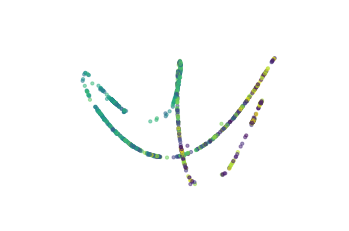

In [16]:
plot(x_recon[:1000], y_train[:1000])

# ANALYSIS

In [17]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)#, normalize_cov=0.)
def walk(f, x_arr, branch_factor=20, n_steps=10, max_size=5000):
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
    orig_shape = (-1,) + (x_arr.shape[1:])
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape(orig_shape)
        (x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:max_size]
        x_arr, z_mu, z_sigma_v, z_sigma_lam = x_arr[p], z_mu[p], z_sigma_v[p], z_sigma_lam[p]
        x_arr = x_arr.reshape(orig_shape)
    
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
        
    return x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc

# NOW GENERATE all data points
max_size = 5000
x_arrs = []
test_size = len(x_train)
n_ = 0
while n_ < test_size:
    p = np.random.permutation(len(x_test))[:200]
    x_test_sample = x_test[p]
    x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=4, branch_factor=2, max_size=max_size)
    x_arrs.append(x_arr)
    n_ += len(x_arr)
    print("generated {}/{} points".format(n_, test_size))

x_gens = np.concatenate(x_arrs, axis=0)[:len(x_train)]

# COMPUTE GROMOV-WASSERSTEIN
gw = gromorov_wasserstein_d(x_train, x_gens)

# COMPUTE BILIP CONSTANT
Ks = bilip(_x_enc, x_arr, 100)
print('Mean bi-Lipschitz constant: {:.4f} +- {:.4f}'.format(np.mean(Ks), np.std(Ks)))
print('Gromov-wasserstein distance: {:.4f}'.format(gw))

generated 3200/5000 points
generated 6400/5000 points


/home/henry/.local/lib/python3.5/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


98.1715361153539 169.34208863027706 3963.5245707642957 6.116549549065253


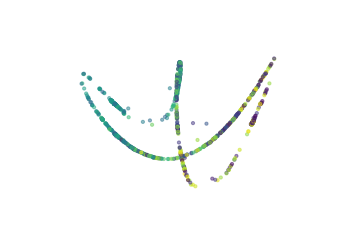

In [22]:
# pick subset size
n_p = min(1000, len(x_train))
p = np.random.permutation(len(x_train))[:n_p]
x_train_p = x_train[p]
y_train_p = y_train[p]

# plot generated points
x_gen = svg.generate_from_samples(x_train_p, normalize_cov=False)
g = plot(x_gen, y_train_p, x2=x_train_p, s2=0)
p_train = np.random.permutation(len(x_train))[:n_p]

### RANDOM WALK TESTING

In [24]:
p = np.random.permutation(len(x_test))[:1]
x_test_sample = x_test[p]
print('random walking on {}'.format(y_test[p]))
# x_test_sample = x_train[y_train == 5]
x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=10)

random walking on [1.08573442]


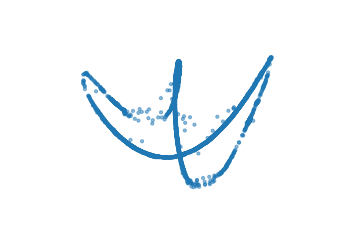

In [25]:
p = np.random.permutation(len(x_arr))
x_true_n_gen = np.concatenate([x_test_sample, x_arr[p]], axis=0)
g = plot(x_true_n_gen, shuffle=False)

Text(0.5, 0.92, 'predicted vs true points in data space')

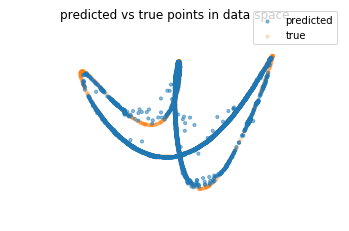

In [26]:
g, ax = plot(x_arr, x2=x_test, label1='predicted', label2='true', alpha2=0.2)
plt.title('predicted vs true points in data space')

Text(0.5, 1.0, 'predicted vs true points in latent space')

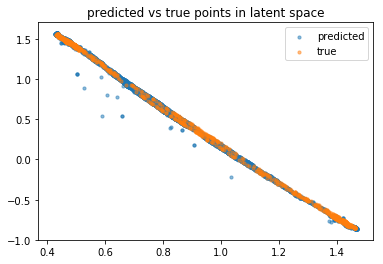

In [27]:
g = plot(z_mu, x2=f(x_test)[1], label1='predicted', label2='true')
plt.title('predicted vs true points in latent space')

Text(0.5, 0.92, 'predicted vs initial seed point in data space')

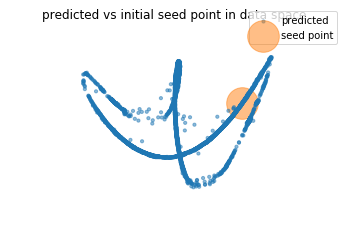

In [28]:
g = plot(x_arr, x2=x_test_sample, label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in data space')

Text(0.5, 1.0, 'predicted vs initial seed point in latent space')

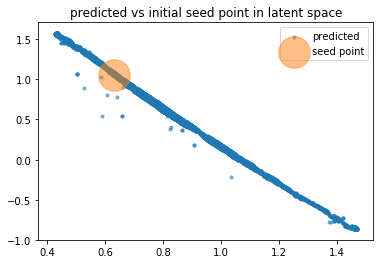

In [29]:
g = plot(z_mu, x2=f(x_test_sample)[1], label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in latent space')